# Прогнозирование цен акций

## Загрузка библиотек

In [1]:
%pylab inline
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import normalize
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import requests
import apimoex
import yfinance as yf
import plotly
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.graph_objects as go
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

Populating the interactive namespace from numpy and matplotlib


## Среднегодовое фундаментальное обучение на российских акциях

Моссбиржа предоставляет большое разнообразие данных по рынкам в свободном доступе. Однако в таком режиме, в отличие от платной подписки, есть возможность следить за рынком с 15 минутной задержкой. Но нам этого вполне достаточно.

### Загрузка минутных котировок акции с Мосбиржи

In [2]:
def take_data(stock, start = None):
    with requests.Session() as session:
        data = apimoex.get_board_candles(session, stock, 1, start=start)
        df = pd.DataFrame(data)
        df.begin = pd.to_datetime(df.begin)
        df.set_index('begin', inplace=True)
    return df

In [3]:
df = take_data('SBER', start = '2021-05-12')
go.Figure(go.Ohlc(x=df.index, open=df.open, high=df.high, low=df.low, close=df.close))
# df.close.iplot()

### Загрузка данных по акциям с Мосбиржи

In [4]:
request_url = ('https://iss.moex.com/iss/engines/stock/markets/shares/securities.json')

with requests.Session() as session:
    iss = apimoex.ISSClient(session, request_url)
    data = iss.get()
    df = pd.DataFrame(data['securities'])
    df = df[df.BOARDID=='TQBR'].set_index('SECID')
df.head()

,BOARDID,SHORTNAME,PREVPRICE,LOTSIZE,FACEVALUE,STATUS,BOARDNAME,DECIMALS,SECNAME,REMARKS,...,ISSUESIZE,ISIN,LATNAME,REGNUMBER,PREVLEGALCLOSEPRICE,PREVADMITTEDQUOTE,CURRENCYID,SECTYPE,LISTLEVEL,SETTLEDATE
SECID,,,,,,,,,,,,,,,,,,,,,
ABRD,TQBR,АбрауДюрсо,200.000,10,1.00,A,Т+: Акции и ДР - безадрес.,1,Абрау-Дюрсо ПАО ао,None,...,98000184,RU000A0JS5T7,Abrau-Durso ao,1-02-12500-A,200.00,200.00,SUR,1,3,2021-05-14
ACKO,TQBR,АСКО ао,6.040,100,1.00,A,Т+: Акции и ДР - безадрес.,2,АСКО-СТРАХОВАНИЕ ПАО ао,None,...,536000000,RU000A0JXS91,ASKO-STRAKHOVANIE ao,1-01-52065-Z,6.04,6.04,SUR,1,3,2021-05-14
AFKS,TQBR,Система ао,33.269,100,0.09,A,Т+: Акции и ДР - безадрес.,3,"АФК ""Система"" ПАО ао",None,...,9650000000,RU000A0DQZE3,AFK Sistema,1-05-01669-A,32.99,32.99,SUR,1,1,2021-05-14
AFLT,TQBR,Аэрофлот,66.320,10,1.00,A,Т+: Акции и ДР - безадрес.,2,Аэрофлот-росс.авиалин(ПАО)ао,None,...,2444535448,RU0009062285,Aeroflot,1-01-00010-A,66.04,66.04,SUR,1,1,2021-05-14
AGRO,TQBR,AGRO-гдр,918.400,1,0.00,A,Т+: Акции и ДР - безадрес.,1,ГДР ROS AGRO PLC ORD SHS,None,...,0,US7496552057,GDR ROS AGRO PLC ORD SHS,None,918.40,918.40,SUR,D,1,2021-05-14


In [5]:
all_rus_stocks = df.index

### Разделение акций по отраслям с Мосбиржи

In [6]:
# industry = pd.read_excel('https://fs.moex.com/files/16036')
industry = pd.read_csv('industry').rename(columns = {'Code':'ticker', 'Sector (rus)':'sector'})[['ticker', 'sector']]
industry[12:17]

,ticker,sector
12,PIKK,Строительство
13,SMLT,Строительство
14,AGRO,Потребительский сектор
15,APTK,Потребительский сектор
16,AQUA,Потребительский сектор


In [7]:
rus_stocks = industry.ticker
sectors = industry.value_counts().index

Однако фундаментальных данных по компаниям найти не удалось, поэтому будем искать альтернативы.

### Загрузка фундаментальных данных со Smart-lab

На данном сайте есть большое количество фундаментальных данных по российским акциям, благо даже есть ссылка на скачивание csv таблиц для каждой из них: https://smart-lab.ru/q/POLY/f/y/MSFO/.

In [8]:
def smartlab(ticker, frequency='y'):
    if frequency == 'y':
        df = pd.read_csv("https://smart-lab.ru/q/{}/f/y/MSFO/download/".format(str(ticker)), sep=';', index_col='Unnamed: 0')
    elif frequency == 'q':
        df = pd.read_csv("https://smart-lab.ru/q/{}/f/q/MSFO/download/".format(str(ticker)), sep=';', index_col='Unnamed: 0')
    return df.T.dropna(axis='columns', how='all')

In [9]:
smartlab('SBER', 'y').tail()

,Дата отчета,"Чистый операц доход, млрд руб","Чист. проц. доходы, млрд руб","Чист. комисс. доход, млрд руб","Доходы по цб, млрд руб","Чистая прибыль, млрд руб","Див.выплата, млрд руб","Дивиденд, руб/акцию","Див доход, ао, %","Дивиденд ап, руб/акцию",...,"EPS, руб","ROE, %","ROA, %","Чистая процентная маржа, %","Рентабельность банка, %","P/E,","P/B,","Персонал, чел","Производительность труда, млн руб/чел/год","Расходы/чел/год, тыс.р"
2017,17.04.2018,1903,1349,"394,2",NaN,"748,7","271,0",12,"5,3%",12,...,"34,7","24,2%","2,9%","6,00%","39,3%","6,74","1,47",310300,"6,13",1298
2018,28.02.2019,1936,1397,"445,3",NaN,"831,7","361,0",16,"8,6%",16,...,"38,5","23,1%","3,2%","5,70%","43,0%","5,04","1,09",293800,"6,59",1376
2019,27.02.2020,2013,1416,"497,9",NaN,"845,0","422,4","18,7","7,3%","18,7",...,"39,1","22,2%","3,1%","5,16%","42,0%","6,78","1,28",281300,"7,16",1599
2020,04.03.2021,2193,1608,"553,0",NaN,"761,0","422,4","18,7","6,1%","18,7",...,"35,3","16,1%","2,3%","5,47%","34,7%","9,04","1,37",285600,"7,68",1632
LTM,NaN,2273,1658,"560,9",NaN,"945,3","422,0","18,7","6,1%","18,7",...,"43,8","24,3%","3,3%","5,40%","41,6%","7,28","1,31",278200,"8,17",1725


In [10]:
smartlab('SBER', 'q').tail()

,Дата отчета,"Чистый операц доход, млрд руб","Чист. проц. доходы, млрд руб","Чист. комисс. доход, млрд руб","Доходы по цб, млрд руб","Чистая прибыль, млрд руб","Див.выплата, млрд руб","Дивиденд, руб/акцию","Див доход, ао, %","Дивиденд ап, руб/акцию",...,"EV, млрд руб","EPS, руб","ROE, %","ROA, %","Чистая процентная маржа, %","Рентабельность банка, %","P/E,","P/B,","Персонал, чел","Расходы/чел/год, тыс.р"
2020Q2,30.07.2020,"514,9","398,5","120,0",NaN,"166,7",NaN,NaN,NaN,NaN,...,4586,"7,72","14,2%","2,1%","5,61%","32,4%","7,00","0,94",276600,"397,7"
2020Q3,29.10.2020,"592,6","411,3","147,7",NaN,"271,4",NaN,NaN,NaN,NaN,...,5153,"12,6","22,8%","3,2%","5,48%","45,8%","6,69","1,07",278200,"371,0"
2020Q4,04.03.2021,"576,9","426,3","158,9",NaN,"202,4","422,0","18,7","6,9%","18,7",...,6091,"9,38","16,6%","2,2%","5,34%","35,1%","8,00","1,22",285600,"510,5"
2021Q1,29.04.2021,"589,0","421,5","134,3",NaN,"304,8",NaN,NaN,NaN,NaN,...,6881,"14,1","24,3%","3,3%","5,18%","51,7%","7,28","1,31",278200,"434,9"
LTM,NaN,2273,1658,"560,9",NaN,"945,3","422,0","18,7","6,1%","18,7",...,6881,"43,8","24,3%","3,3%","5,40%","41,6%","7,28","1,31",278200,1725


Такого типа данные заполняются вручную из отчетов компаний, поэтому на удобство использования и полноту данных расчитывать не приходится.
**LTM** - данные за последние четыре квартала. Могут пригодиться, но из обучения убираем.

Итак, функция, собирающая полную таблицу по списку тикеров:

In [11]:
def table_smartlab(tickers, *args):
    LTM = []
    broken_list = []
    data_stocks = []
    for ticker in tickers:
        try:
            dat = smartlab(ticker, *args)
            dat['SECID'] = ticker
            LTM.append(dat.loc['LTM'])
            data_stocks.append(dat.drop('LTM'))
        except Exception:
            broken_list.append(ticker)
            continue
        
    LTM = pd.concat(LTM, 1).T.rename(columns={'SECID':'ticker'}).set_index('ticker').dropna(axis='columns', how='all')
    LTM = LTM.replace('%', ' ', regex=True).replace(',', '.', regex=True)
    LTM.columns = LTM.columns.str.strip()
    
    table = pd.concat(data_stocks, axis=0).rename(columns={'SECID':'ticker'})
    table.index.names = ['year']
    table.reset_index(inplace=True)
    table = table.groupby(['ticker', 'year']).first()
    table = table.replace('%', ' ', regex=True).replace(',', '.', regex=True)
    table.columns = table.columns.str.strip()
    return table, LTM

In [12]:
# table, LTM = table_smartlab(rus_stocks, 'y')

Добавим разделение по отраслям:

In [13]:
# table = table.reset_index().merge(industry, on='ticker').set_index(['ticker', 'year'])
# LTM = LTM.reset_index().merge(industry, on='ticker').set_index('ticker')

Здесь и далее будем сразу сохранять скачанные данные и впоследствии подгружать с диска:

In [14]:
table = pd.read_csv('fundamental.csv', index_col=['ticker', 'year'])
LTM = pd.read_csv('LTM.csv', index_col='ticker')

In [15]:
table[10:15]

Дата отчета  Выручка, млрд руб  EBITDA, млрд руб  \
ticker year                                                    
AFKS   2018  03.04.2019              777.4             265.3   
       2019  07.04.2020              656.9             223.9   
       2020  08.04.2021              691.6             236.3   
AFLT   2008         NaN                NaN               NaN   
       2009         NaN                NaN               NaN   

             Чистая прибыль н/с, млрд руб  Чистая прибыль, млрд руб  \
ticker year                                                           
AFKS   2018                         -45.9                      1.11   
       2019                          28.6                     53.40   
       2020                          10.2                     16.00   
AFLT   2008                           NaN                       NaN   
       2009                           NaN                       NaN   

             Див.выплата, млрд руб  Дивиденд, руб/акцию  Див доход, ао, %  \
ticker year                                                                 
AFKS   2018                  1.060                 0.11               1.4   
       2019                  1.250                 0.13               0.9   
       2020                    NaN                  NaN               NaN   
AFLT   2008                  0.200                 0.18               0.7   
       2009                  0.388                 0.35               0.7   

             Дивиденды/прибыль, %  Себестоимость, млрд руб  ...  \
ticker year                                                 ...   
AFKS   2018                  95.0                    366.0  ...   
       2019                   2.0                    301.9  ...   
       2020                   NaN                    330.0  ...   
AFLT   2008                   NaN                      NaN  ...   
       2009                   NaN                      NaN  ...   

             Акт. абоненты, млн чел  ARPU, $/чел  \
ticker year                                        
AFKS   2018                     NaN          NaN   
       2019                     NaN          NaN   
       2020                     NaN          NaN   
AFLT   2008                     NaN          NaN   
       2009                     NaN          NaN   

             Пассажиропоток всего, млн чел  Пассажиропоток внутр, млн чел  \
ticker year                                                                 
AFKS   2018                            NaN                            NaN   
       2019                            NaN                            NaN   
       2020                            NaN                            NaN   
AFLT   2008                            NaN                            NaN   
       2009                            NaN                            NaN   

             Пассажиропоток м/нар, млн чел  Занятость пассаж.кресел, %  \
ticker year                                                              
AFKS   2018                            NaN                         NaN   
       2019                            NaN                         NaN   
       2020                            NaN                         NaN   
AFLT   2008                            NaN                         NaN   
       2009                            NaN                         NaN   

             Грузооборот, млн т  Часы налета, ч  Число самолетов, шт  \
ticker year                                                            
AFKS   2018                 NaN             NaN                  NaN   
       2019                 NaN             NaN                  NaN   
       2020                 NaN             NaN                  NaN   
AFLT   2008                 NaN             NaN                  NaN   
       2009                 NaN             NaN                  NaN   

                sector  
ticker year             
AFKS   2018   Холдинги  
       2019   Холдинги  
       2020   Холдинги  
A

### Загрузка котировок с Мосбиржи или Yahoo Finance

Напишем наперед три потенциально полезные функции:
   * Ежедневные цены закрытия акции (скачиваются напрямую с Мосбиржи или Yahoo Finance)
   * Среднемесячные цены акции (высчитываются по значениям предыдущего пункта)
   * Среднегодовые цены акции (высчитываются по значениям предыдущего пункта)

In [16]:
def Daily_close(ticker, from_='MOEX', ru=True, start = None):
    if from_ == 'MOEX':
        with requests.Session() as session:
            data = apimoex.get_board_candles(session, ticker, start=start)
            df = pd.DataFrame(data)
            df.begin = pd.to_datetime(df.begin)
            df.set_index('begin', inplace=True)
            df.index.names = ['Date']
    elif from_ == 'yahoo':
        if ru:
            ticker = ticker + '.ME' 
        df = yf.download(ticker)
        df.columns = df.columns.str.lower()
    return df

In [17]:
def AverageMonth(ticker, *args, **kwargs):
    df = Daily_close(ticker, *args, **kwargs)
    val, ye, mo = [], [], []
    for y in sorted(set(df.index.year)):
        for m in set(df.index[df.index.year == y].month):
            month = df.loc[(df.index.year == y)&(df.index.month == m), 'close']
            val.append(np.round(month.sum()/len(month), 2))
            ye.append(y)
            mo.append(m)
    d = pd.DataFrame(np.array([ye, mo, val]).T, columns=['year', 'month', 'close'])
    d.year = d.year.astype(int)
    d.month = d.month.astype(int)
    d['ticker'] = ticker
    d['day'] = np.ones(len(d))
    d['date'] = pd.to_datetime(d[['year', 'month', 'day']])
    d.set_index('date', inplace=True)
    d = d[['close', 'ticker']]
    return d

In [18]:
def AverageYear(ticker, *args, **kwargs):
    df = AverageMonth(ticker, *args, **kwargs)
    val, ye = [], []
    for y in sorted(set(df.index.year)):
        year = df.loc[df.index.year == y, 'close']
        val.append(np.round(year.sum()/len(year), 2))
        ye.append(y)
    d = pd.DataFrame(np.array([ye, val]).T, columns = ['year', 'close'])
    d.year = d.year.astype(int)
    d['ticker'] = df.ticker[0]
    d.set_index('year', inplace=True)
    return d

In [19]:
K = AverageYear('POLY', start = '2020-01-01')
K

,close,ticker
year,,
2020,1488.83,POLY
2021,1625.69,POLY


### Первичный отбор признаков

Аналитически подберем несколько важных признаков и будем считать их основными:

In [20]:
main_features = ['ROE, %', 'Чистая рентаб, %', 'Рентаб EBITDA, %', 'Долг/EBITDA,', 'P/E,', 'P/S,', 'P/BV,', 'EV/EBITDA,']

Text(0.5, 0.98, 'Heatmap of the main features')

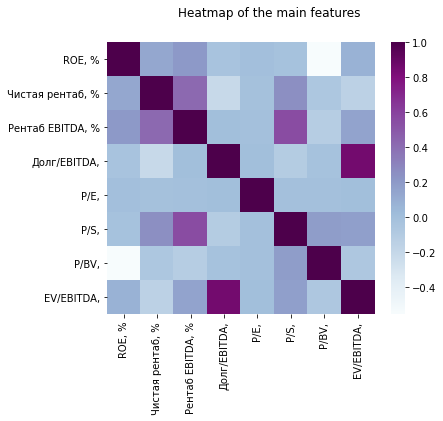

In [21]:
fig = plt.figure(figsize=(6,5))
sns.heatmap(table[main_features].corr(), cmap='BuPu')
plt.suptitle('Heatmap of the main features')

Также напишем функцию для сортировки признаков, работать которая будет в три этапа: 
   * Избавляемся от признаков, в которых доля *NA* превышает **max_portion_NA**. 
   * В коррелляционной матрице вычеркиваем значения, корелляция которых больше **max_corr_value**.
   * Для каждого признака считаем количество вычеркнутых значений и выбрасываем те, у кого это количество превышает **max_num_bad_feats**.

In [22]:
def best_feats(table, max_portion_NA, max_corr_value, max_num_bad_feats):
    top_na = table.isna().sum().sort_values()/len(table)
    corr = table[top_na[top_na < max_portion_NA].index].corr()
    k = corr[(corr < max_corr_value)|(corr==1)].isna().sum().sort_values()
    return k[k < max_num_bad_feats + 1].index

best_features = best_feats(table, max_portion_NA = 0.6, max_corr_value = 0.6, max_num_bad_feats = 2)

Text(0.5, 0.98, 'Heatmap of the best features')

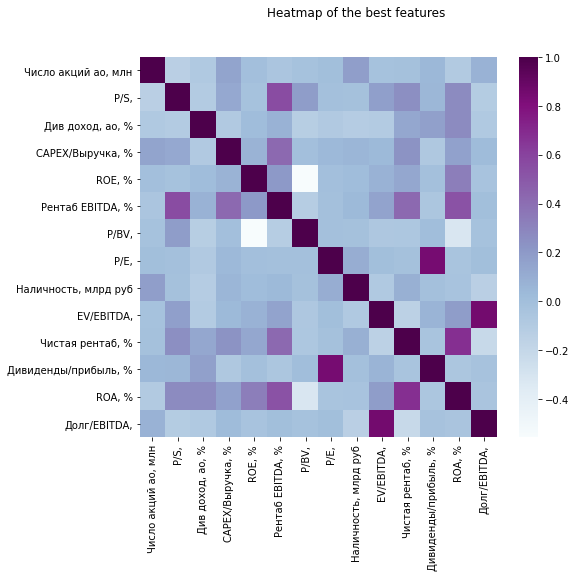

In [23]:
fig = plt.figure(figsize=(8,7))
sns.heatmap(table[best_features].corr(), cmap='BuPu')
plt.suptitle('Heatmap of the best features')

Итак, имеем матрицу признаков, состоящую из фундаментальных показателей, теперь необходимо подготовить целевой параметр, который мы будем предсказывать.

In [24]:
table[main_features].dropna()

ROE, %  Чистая рентаб, %  Рентаб EBITDA, %  Долг/EBITDA,    P/E,  \
ticker year                                                                     
AFKS   2013    11.1               8.8              21.8          0.07    8.36   
       2014    -8.2              -3.0              25.6          2.62   -5.75   
       2015    -2.4              -0.9              26.0          2.20  -29.10   
       2016     0.7               0.2              26.9          2.03  151.00   
       2017     8.6               0.6              28.3          2.65   28.30   
...             ...               ...               ...           ...     ...   
YNDX   2016    18.3              18.6              34.4         -1.70   29.20   
       2017    18.5              16.3              30.9         -1.65   40.70   
       2018    12.1              17.3              31.0         -1.74   28.80   
       2019    12.1              13.4              29.1         -1.73   37.80   
       2020     6.4               9.6              22.8         -3.11   74.00   

             P/S,  P/BV,  EV/EBITDA,  
ticker year                           
AFKS   2013  0.73   1.23        3.44  
       2014  0.17   1.23        3.29  
       2015  0.25   1.98        3.17  
       2016  0.32   3.92        3.22  
       2017  0.17  -1.12        3.23  
...           ...    ...         ...  
YNDX   2016  5.42   6.52       14.10  
       2017  6.65   9.13       19.80  
       2018  4.99   5.40       14.40  
       2019  5.08   6.73       15.70  
       2020  7.12   7.87       28.10  

[548 rows x 8 columns]

### Подготовка целевой функции

Данные по признакам у нас имеются с годовой частотой, значит более частые предсказания делать смысла нет. Также считаем, что фундаментальные показатели посчитанные за текущий год влияют только на следующий, тогда предсказывать будем **изменение цены акции с текущего года на следующий**. Задача временного ряда свелась к влиянию набора показателей за один год на единственное значение **изменения цены** за следующий. 

Данные по котировкам, на удивление, попадаются неполные, хотя казалось, узкое горлышко уже пройдено. К тому же, не везде совпадают с разных источников.

In [25]:
pd.concat([table[main_features].loc['AFKS'].dropna(),
           AverageYear('AFKS', 'yahoo').close.rename('yahoo_close'),
               AverageYear('AFKS', 'MOEX').close.rename('MOEX_close')], 1)

[*********************100%***********************]  1 of 1 completed


,"ROE, %","Чистая рентаб, %","Рентаб EBITDA, %","Долг/EBITDA,","P/E,","P/S,","P/BV,","EV/EBITDA,",yahoo_close,MOEX_close
year,,,,,,,,,,
2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.23,NaN
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.23,NaN
2013,11.1,8.8,21.8,0.07,8.36,0.73,1.23,3.44,30.44,NaN
2014,-8.2,-3.0,25.6,2.62,-5.75,0.17,1.23,3.29,32.79,27.93
2015,-2.4,-0.9,26.0,2.20,-29.10,0.25,1.98,3.17,17.56,17.57
2016,0.7,0.2,26.9,2.03,151.00,0.32,3.92,3.22,20.13,20.13
2017,8.6,0.6,28.3,2.65,28.30,0.17,-1.12,3.23,15.92,15.92
2018,6.5,0.1,34.1,2.21,69.30,0.10,-0.50,2.50,9.83,9.84
2019,129.0,8.1,34.1,2.60,2.75,0.22,-1.40,3.26,11.25,11.25


Поэтому напишем функцию с выбором источника:

In [26]:
def X_with_y(X, kind='MOEX', feat_normed = False):
#     X = X.dropna()
    X_new = []
    for ticker in sorted(set(X.reset_index().ticker)):
        try:    
            if kind=='MOEX':
                K = AverageYear(ticker, 'MOEX').join(X.loc[ticker])
                
            if kind=='yahoo':
                K = AverageYear(ticker, 'yahoo').join(X.loc[ticker])
                
            if kind=='both':
                data = []
                data.append(AverageYear(ticker, 'MOEX'))
                data.append(AverageYear(ticker, 'yahoo'))
                K = data[np.argmin([data[0].index.min(), data[1].index.min()])].join(X.loc[ticker])
                
            K['change'] = K.close.shift(-1) - K.close
            K['change_%'] = (K.close.shift(-1) - K.close)/K.close
            K = K[K.close>0.5]
            
            if feat_normed:
                median = K[X.columns].median()
                K[median.index] /= median
                
            X_new.append(K)
        except Exception:
            continue
            
    X_new = pd.concat(X_new).reset_index().set_index(['ticker', 'year'])
    return X_new

Чтобы корректно обучаться по целевому признаку, его нужно некоторым образом нормировать. Деление на медиану цен для каждой акции неплохо справляется с этой задачей. Теперь величина иземенения цен соотвествует своему размеру для акций разных ценовых категорий.

In [27]:
# X_y = X_with_y(table, feat_normed=False)

In [28]:
# X_y.to_csv('X_y.csv')

In [29]:
X_y = pd.read_csv('X_y.csv', index_col=['ticker', 'year'])
X_y_norm = pd.read_csv('X_y_norm.csv', index_col=['ticker', 'year'])

### TSNE или вторичный отбор признаков

In [30]:
with pd.option_context('mode.use_inf_as_na', True):
    X = X_y_norm[[*main_features, 'sector']].dropna()
tsne = TSNE().fit_transform(X.drop('sector', 1))
print(tsne.shape)
X['x'] = tsne[:, 0]
X['y'] = tsne[:, 1]

(405, 2)


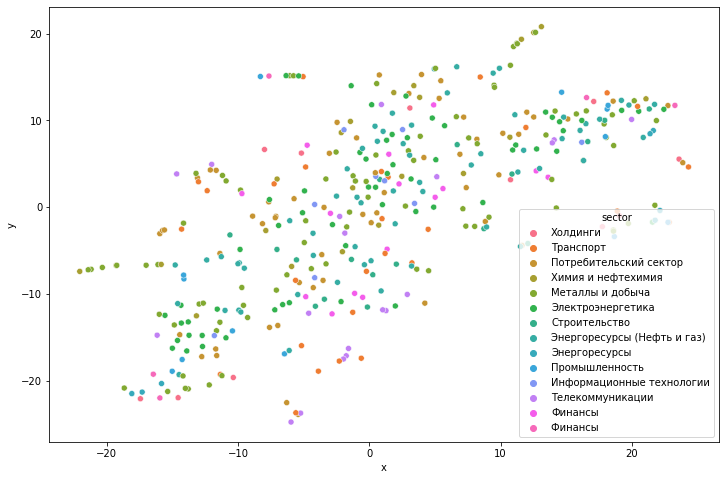

In [31]:
X = X.reset_index()
plt.figure(figsize(12, 8))
sns.scatterplot(data=X, x='x', y='y', hue=X['sector'])
X = X.set_index(['ticker', 'year'])

### Последняя подготовка данных и борьба с выбросами

In [32]:
X_y = pd.read_csv('X_y.csv', index_col=['ticker', 'year'])

<AxesSubplot:xlabel='change_%', ylabel='Count'>

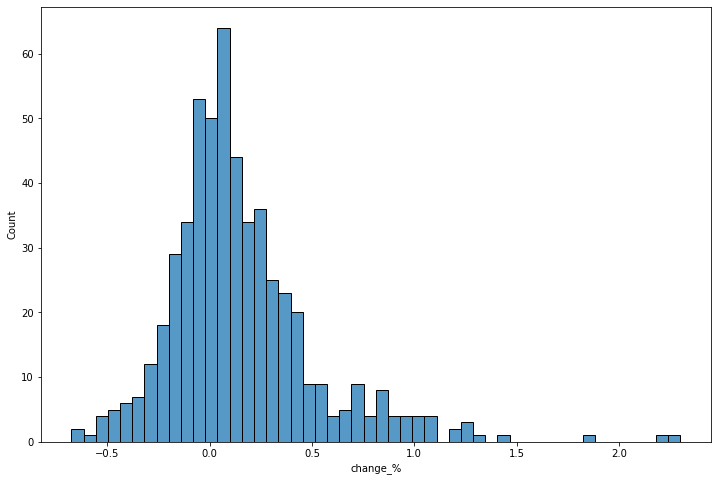

In [33]:
sns.histplot(X_y['change_%'], bins=50)

In [34]:
X_prep = X_y[[*main_features, 'close', 'change_%', 'sector']].dropna()
X_test = X_prep.reset_index()[X_prep.reset_index().year==2020].set_index(['ticker', 'year'])
X_train = X_prep.reset_index()[X_prep.reset_index().year!=2020].set_index(['ticker', 'year'])

In [35]:
X_train.drop(('KMAZ', 2015), inplace=True)
X_train.drop(('NMTP', 2016), inplace=True)
X_train.drop(('MTSS', 2017), inplace=True)
X_train.drop(('MSTT', 2019), inplace=True)
X_train.drop(('OPIN', 2015), inplace=True)
X_train.drop(('OPIN', 2016), inplace=True)
X_train.drop(('OPIN', 2017), inplace=True)

### Метрики качества 

Осталось придумать как мы будем сравнивать качество модели. 

В первую очередь нас интересует сколько ростов и падений акций модель угадала, назовем **accuracy**:

In [36]:
def accuracy(a, b):
    right = np.sign(X_test['price_change'])==np.sign(X_test['price_change_pred'])
    return right.sum()/len(right)

Также интересует насколько сильно модель ошиблась, для этого посчитаем абсолютную ошибку. Но опять же, так как цены акций могут быть в разных ценовых категориях, необходимо привести некоторую нормировку, причем симметрично относительно предсказанной и настоящей величинами.
   1. Считаем разность
   2. В зависимости от знаков исходных величин и разности проводим нормировку, переводя разность в симметричный интервал около 0
   3. Модулем отражаем в положительную ось, переводя интервал, строго говоря, к $[0, \infty )$. 
   
Теперь при уменьшении метрики, увеличивается качество.

In [37]:
def AE(a, b):
    k = a - b
    data = k.copy()
    data.loc[(a > 0)&(k>0)] /= a[((a > 0)&(k>0))]
    data.loc[(a > 0)&(k<0)] /= b[((a > 0)&(k<0))]
    data.loc[(a < 0)&(k<0)] /= a[((a < 0)&(k<0))]
    data.loc[(a < 0)&(k>0)] /= b[((a < 0)&(k>0))]
    return data.abs()

### Непосредственно обучение

#### Линейная регрессия

In [38]:
m2 = sm.OLS(X_train['change_%'], X_train[main_features])
fitted = m2.fit(cov_type='HC1')
print(fitted.summary())

                                 OLS Regression Results                                
Dep. Variable:               change_%   R-squared (uncentered):                   0.181
Model:                            OLS   Adj. R-squared (uncentered):              0.161
Method:                 Least Squares   F-statistic:                              9.345
Date:                Wed, 12 May 2021   Prob (F-statistic):                    1.26e-11
Time:                        15:01:19   Log-Likelihood:                         -97.804
No. Observations:                 336   AIC:                                      211.6
Df Residuals:                     328   BIC:                                      242.1
Df Model:                           8                                                  
Covariance Type:                  HC1                                                  
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning:

invalid value encountered in log



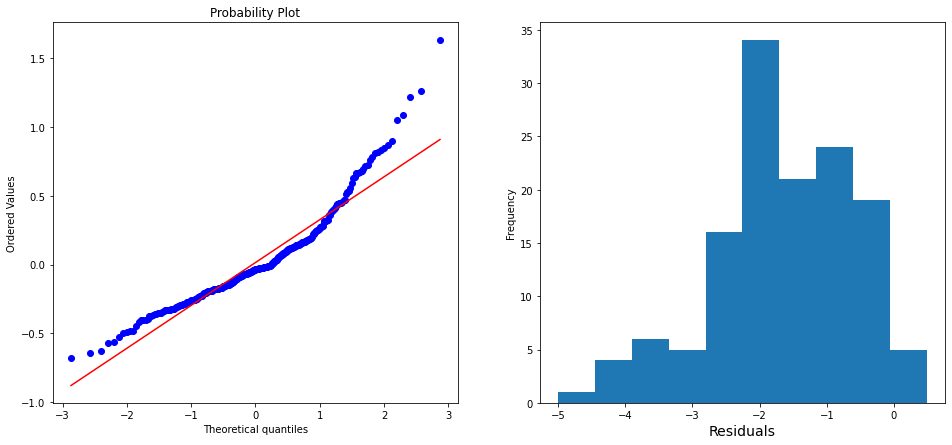

In [39]:
plt.figure(figsize(16,7))
plt.subplot(121)
stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

<Figure size 576x504 with 0 Axes>

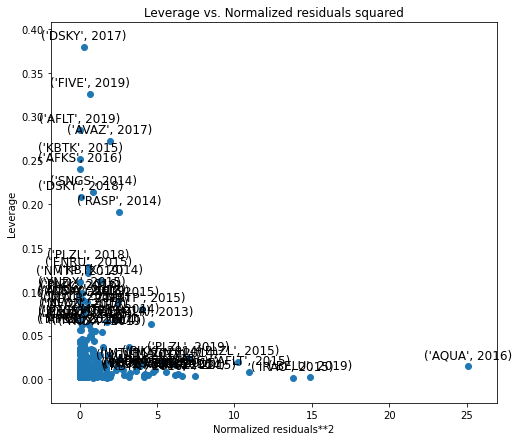

In [40]:
plt.figure(figsize(8,7))
plot_leverage_resid2(fitted)
pylab.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='change_%'>

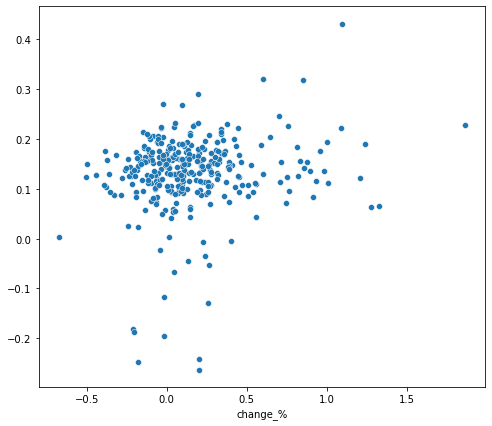

In [41]:
sns.scatterplot(X_train['change_%'], fitted.fittedvalues)

In [42]:
X_test['change_%_pred'] = fitted.predict(X_test[main_features])

In [43]:
X_test[['change_%','change_%_pred']].iplot()

In [44]:
X_test['metric'] = AE(X_test['change_%'], X_test['change_%_pred'])
print('sum_metric: ', X_test['metric'].sum())

X_test.sort_values('metric')[:10][['close','change_%', 'change_%_pred', 'metric']]

sum_metric:  2785.7491910782046


,,close,change_%,change_%_pred,metric
ticker,year,,,,
AKRN,2020,5719.32,0.057491,0.058188,0.011970
HYDR,2020,0.71,0.154930,0.150047,0.031514
MSRS,2020,1.16,0.094828,0.098210,0.034441
MDMG,2020,463.81,0.168862,0.163031,0.034533
LSRG,2020,774.45,0.122629,0.129027,0.049588
OGKB,2020,0.69,0.144928,0.136595,0.057491
YNDX,2020,3730.17,0.317334,0.286533,0.097062
AQUA,2020,232.06,0.182625,0.149335,0.182287
RTKM,2020,88.27,0.190212,0.149699,0.212990


In [45]:
def sort_forecast_for_today(X_test, today='2021-05-07'):
    if X_test.index[0][1]!=2021:
        print('Для предсказания на сегодня необходимы данные за 2021 год')
        return
    df = X_test.copy()
    df['prediction_2021'] = df['close'] + df['change_%_pred']
    df.reset_index(inplace=True)
    for ticker in df.ticker:
        df.loc[df.ticker==ticker, today] = Daily_close(ticker, start=today).close.loc[today]

    df['metric_for_today'] = AE(df['prediction_2021'], df[today])
    new_column = 'price_'+str(df.year[0])
    df.rename(columns={'close': new_column}, inplace=True)
    df = df.drop('year', 1).set_index('ticker')
    return df.sort_values('metric_for_today')[[new_column, 'prediction_2021', today, 'metric_for_today']]

In [46]:
sort_forecast_for_today(X_test, today='2021-05-12')

Для предсказания на сегодня необходимы данные за 2021 год


### Сортировка российских акций по фундаментальным показателям

Самое полезное, как можно использовать эти показатели, сделать ручную сортировку.

In [47]:
LTM[main_features]

,"ROE, %","Чистая рентаб, %","Рентаб EBITDA, %","Долг/EBITDA,","P/E,","P/S,","P/BV,","EV/EBITDA,"
ticker,,,,,,,,
AKRN,9.0,3.2,29.5,2.82,63.10,2.02,5.67,9.68
NKNC,6.5,5.8,18.9,2.79,18.30,1.07,1.20,8.44
PHOR,44.3,18.4,33.2,1.79,12.10,2.22,5.43,8.48
AFKS,24.7,2.3,34.2,2.58,19.90,0.46,-3.45,3.93
ENPL,31.4,9.8,18.0,5.41,9.34,0.92,9.50,10.50
...,...,...,...,...,...,...,...,...
FLOT,6.5,19.8,66.8,1.67,11.00,2.18,0.72,4.92
GLTR,22.6,15.5,39.2,1.01,7.81,1.21,1.77,4.10
NKHP,29.2,30.1,44.4,0.05,10.70,3.23,3.13,7.31


In [48]:
# LTM

## Среднегодовое фундаментальное обучение на международных акциях

### Загрузка фундаментальных данных с FinancialModelingPrep

Здесь есть достаточно большой набор фундаментальных показателей как российских, так и иностранных акций, однако преимущественно они имеются начиная только с 2016 года.

In [49]:
# from fmp_python.fmp import FMP
# fmp = FMP(api_key='47a3212d4a233f392d6c193f8fdf26a3')
# fmp.get_quote('SBER.ME')

from urllib.request import urlopen
import json

def get_jsonparsed_data(tocken):
    url = ("https://financialmodelingprep.com/api/v3/ratios/{}?apikey=47a3212d4a233f392d6c193f8fdf26a3".format(tocken))
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return pd.DataFrame(json.loads(data))

df = get_jsonparsed_data('POLY.ME')

In [50]:
df.date = pd.to_datetime(df.date).dt.year
df = df.set_index('date')[df.columns[df.dtypes=='float64']]
df = df[df!=0]
df.dropna(axis='columns',how='any', inplace=True)

Расшифровка обозначений: https://financialmodelingprep.com/developer/docs/#Company-Financial-Ratios

In [51]:
df

,currentRatio,quickRatio,cashRatio,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,grossProfitMargin,operatingProfitMargin,pretaxProfitMargin,...,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue
date,,,,,,,,,,,,,,,,,,,,,
2020,2.175633,0.613924,0.610759,214.021258,214.021258,29.096546,184.924712,0.605934,0.509599,0.490401,...,269.539154,711.077050,1268.029026,647.843689,647.843689,5.618109,269.539154,0.000623,527.321525,385.729109
2019,2.756381,0.587007,0.587007,196.374269,196.374269,22.259816,174.114453,0.465863,0.354752,0.275770,...,220.305404,1028.550853,1898.863113,709.345416,709.345416,35.450981,220.305404,0.000486,616.400261,256.070752
2018,2.893112,0.900238,0.900238,201.858908,201.858908,27.064882,174.794027,0.430832,0.307151,0.244431,...,194.951273,936.864428,1967.969657,648.317489,648.317489,-261.444654,194.951273,0.000640,633.756873,241.179748
2017,3.556075,0.168224,0.168224,169.629295,169.629295,20.461121,149.168174,0.390634,0.279890,0.244077,...,156.699283,803.415813,1896.061318,533.600746,533.600746,-69.641246,156.699283,0.000485,558.209371,217.604589
2016,2.512195,0.167247,0.167247,212.700946,212.700946,22.003546,190.697400,0.465572,0.367656,0.356286,...,181.571813,727.666279,1109.761314,542.317321,542.317321,9.400798,181.571813,0.000550,493.436206,292.995087


### Загрузка 24000 международных акций или парсинг https://vseakcii.ru/issuers/sector

In [52]:
# import requests
# from bs4 import BeautifulSoup

# url = 'https://vseakcii.ru/issuers/sector?limit=-1'
# response = requests.get(url)
# soup = BeautifulSoup(response.text, 'lxml')
# quotes = soup.find_all('tr')

In [53]:
# all_stocks = pd.DataFrame(columns=['ticker','name','country','sector','market','last_report', 'reporting_period'])
# for i, quote in enumerate(quotes[1:]): 
#     all_stocks.loc[i] = (str(quote.find('td', class_='column_1')).split('title="')[1].split('"')[0],
#             str(quote.find('td', class_='column_2')).split('title="')[1].split('"')[0],
#             str(quote.find('td', class_='column_3')).split('column_3">')[1].split('</td>')[0],
#             str(quote.find('td', class_='column_4')).split('title="')[1].split('"')[0],
#             str(quote.find('td', class_='column_5')).split('title="')[1].split('"')[0],
#             str(quote.find('td', class_='column_6')).split('column_6">')[1].split('</td>')[0],
#             str(quote.find('td', class_='column_7')).split('column_7">')[1].split('</td>')[0])

In [54]:
all_stocks = pd.read_csv('all_stocks.csv')

In [55]:
all_stocks[all_stocks.country=='Россия']

,ticker,name,country,sector,market,last_report,reporting_period
15,QIWI,QIWI,Россия,Кредитные услуги,MOEX,15 апр. 2021,4 кв. 2020
59,SBER,Сбербанк,Россия,Банки - Региональные,MOEX,29 апр. 2021,1 кв. 2021
60,SBERP,Сбербанк-п,Россия,Банки - Региональные,MOEX,29 апр. 2021,1 кв. 2021
63,GLTR,Globaltrans,Россия,Железные дороги,LSE,29 мар. 2021,2 пг. 2020
131,BSPB,Банк Санкт-Петербург,Россия,Банки - Региональные,MOEX,10 мар. 2021,4 кв. 2020
...,...,...,...,...,...,...,...
6459,RTKMP,Ростелеком-п,Россия,Телекоммуникации,MOEX,9 мар. 2021,4 кв. 2020
6460,NKNCP,НКНХ-п,Россия,Специальные химические вещества,MOEX,29 мар. 2021,2 пг. 2020
6469,MGTSP,МГТС-п,Россия,Телекоммуникации,MOEX,23 мар. 2021,2 пг. 2020
6470,ENPG,ЭН+ ГРУП,Россия,Алюминий,MOEX,25 мар. 2021,4 кв. 2020


In [56]:
all_stocks.sector.value_counts()[:20]

Управление активами                      1149
Промышленные металлы и минералы          1120
Биотехнологии                             928
Программное обеспечение - Прикладное      759
Специальное промышленное оборудование     749
Банки - Региональные                      638
Золото                                    581
Инжиниринг и строительство                580
Производители дженериков                  522
Электронные компоненты                    451
Услуги в сфере недвижимости               437
ИТ-услуги                                 432
Специальные химические вещества           426
Нефть и газ - Разведка и добыча           399
Автозапчасти                              396
Упакованные продукты питания              378
Электрооборудование и запчасти            345
Девелопмент                               322
Оборудование для связи                    320
Фондовый рынок                            302
Name: sector, dtype: int64